In [4]:
import numpy as np
import numpy.typing as npt

import matplotlib.pyplot as plt

In [5]:
# reference: https://stackoverflow.com/questions/14465297/connected-component-labeling-implementation
# perform depth first search for each candidate/unlabeled region
dx = [+1, 0, -1, 0]
dy = [0, +1, 0, -1]

def dfs(mask: npt.NDArray, x: int, y: int, labels: npt.NDArray, current_label: int):
    n_rows, n_cols = full_mask.shape
    if x < 0 or x == n_rows:
        return
    if y < 0 or y == n_cols:
        return
    if labels[x][y] or not mask[x][y]:
        return  # already labeled or not marked with 1 in image

    # mark the current cell
    labels[x][y] = current_label

    # recursively mark the neighbors
    for direction in range(4):
        dfs(mask, x + dx[direction], y + dy[direction], labels, current_label)


def find_components(mask: npt.NDArray):
    label = 0

    n_rows, n_cols = mask.shape
    labels = np.zeros(mask.shape, dtype=np.int8)

    for i in range(n_rows):
        for j in range(n_cols):
            if not labels[i][j] and mask[i][j]:
                label += 1
                dfs(mask, i, j, labels, label)

    return labels

In [6]:
E_MAX = 0.25  # is that correct for both errors?


def extract_region(labels: npt.NDArray, label: int):
    n_rows, n_cols = labels.shape

    contours = np.copy(labels)
    edge_points = []

    # TODO: reduce iter range to BB of target region..
    # find contours of shape with label
    for i in range(n_rows):
        for j in range(n_cols):
            if contours[i][j] == label:
                if (
                    labels[i - 1][j] != 0
                    and labels[i][j - 1] != 0
                    and labels[i + 1, j] != 0
                    and labels[i][j + 1] != 0
                ):
                    contours[i][j] = 0
                else:
                    edge_points.append((i, j))
            else:
                contours[i][j] = 0

    x, y = zip(*edge_points)
    edges = np.array([x, y], dtype=np.float32).T
    # plt.scatter(x, y)
    return edges


def normalize_region(edges):
    center = np.average(edges, axis=0)
    edges -= center

    r_max = 0.0
    r = np.zeros((len(edges)))

    for i, e_i in enumerate(edges):
        r_i = np.linalg.norm(e_i)
        r[i] = r_i
        if r_i > r_max:
            r_max = r_i

    r /= r_max
    edges /= r_max

    return edges, r


def distance_entropy(distances, resolution):
    n_bins = 2 ** resolution
    n_points = len(distances)

    n_per_bin, _ = np.histogram(distances, n_bins, range=[0, 1], density=False)    

    dist_entropy = 0.0
    for n_bin in n_per_bin:
        prob = n_bin / n_points
        if prob > 0:
            dist_entropy -= prob * np.log2(prob)

    return dist_entropy


def quantization_value(values, quantization, k):    
    quantization_level = values[quantization == k]

    quantization_distance_sum = quantization_level.sum()
    n_quantized = len(quantization_level)

    return quantization_distance_sum / n_quantized


def quantization_error(values, resolution, bin_range):
    n_points = len(values)
    start, end = bin_range
    bin_edges = np.linspace(start, end, 2 ** resolution + 1)
    quantization = np.digitize(values, bin_edges)

    error_sum = 0.0

    for i in range(n_points):
        k = quantization[i]
        error_sum += (
            values[i] - quantization_value(values, quantization, k)
        ) ** 2

    return np.sqrt((1 / n_points) * error_sum)


def entropy_quantization_trade_off_cost(entropy_fn, resolution, values, bin_range):
    n_points = len(values)

    dist_entropy = entropy_fn(values, resolution)
    quant_err = quantization_error(values, resolution, bin_range)

    return (dist_entropy / np.log2(n_points)) + (quant_err / E_MAX)


def minimize_cost(entropy_fn, distances, bin_range, resolutions = None):
    fn = lambda j: entropy_quantization_trade_off_cost(entropy_fn, j, distances, bin_range)
    resolutions = np.arange(1, 10) if resolutions is None else resolutions
    res = list(map(fn, resolutions))
    min_i = np.argmin(res)
        
    if min_i == len(resolutions)-1:
        new_min_res = resolutions[-1]
        return minimize_cost(entropy_fn, distances, bin_range, np.arange(new_min_res, new_min_res + 10))

    return res[min_i]


In [7]:
# TODO: implement local angle entropy
def find_local_angles(points, idx):
    p = points[idx]
    nearest_neighbor_idx = np.argmin(
        [
            np.linalg.norm(p - points[i]) if i != idx else np.inf
            for i in range(len(points))
        ]
    )
    nearest_neighbor = points[nearest_neighbor_idx]    

    pred_p = p + (p - nearest_neighbor)
    pred_p_nearest_neighbor = points[
        np.argmin(
            [
                np.linalg.norm(pred_p - points[i])
                if i != idx and i != nearest_neighbor_idx
                else np.inf
                for i in range(len(points))
            ]
        )
    ]

    unit_vector = lambda x: x / np.linalg.norm(x)
    # https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python/13849249#13849249    
    v1_u = unit_vector(p - nearest_neighbor)
    v2_u = unit_vector(pred_p_nearest_neighbor - p)

    angle = np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

    return 2*np.pi - angle if angle > np.pi else angle


def compute_local_angles(points):
    return np.array([find_local_angles(points, i) for i in range(len(points))])


def angle_entropy(local_angles, resolution):
    n_bins = 2 ** resolution
    n_points = len(local_angles)

    n_per_bin, _ = np.histogram(local_angles, n_bins, range=[0, np.pi], density=False)    

    entropy = 0.0
    for n_bin in n_per_bin:
        prob = n_bin / n_points
        if prob > 0:
            entropy -= prob * np.log2(prob)

    return entropy 

In [18]:
# a) 
# Search for the nearest neighbor v_nn1 of a predicted point v_p 
# obtained by using the previous and current point from non-passed 
# points. If the distance between v_nn1 and v_p is less than a 
# threshold δ, connect v_nn1 and v_p and goto v_nn1, 
# otherwise goto sub-step b. 
# (b) 
# Search for the nearest neighbor v_nn2 of current point v_c. 
# If the distance between v_nn2 and v_c is less than δ, connect 
# v_nn2 and v_c and goto v_nn2, 
# otherwise goto sub-step c. 
# (c)
# Search for a passed point v* with minimum distance
# between itself to its nearest neighbor v_nn3 from non-passed points,
# connect v* and v_nn3 and goto v_nn3.

DEBUG = False
DELTA = 0.1 # TODO: might need tweaking
rng = np.random.default_rng()

def trace(points, start_idx):
    N = len(points)
    spanning_tree = np.zeros((N, N))
    available_points = { i: points[i] for i in range(N)}
    
    passed_points = {}
    debug_x = []
    debug_y = []
    previous_idx = None
    current_idx = None

    while True:
        if previous_idx is not None and current_idx is not None:
            spanning_tree[previous_idx, current_idx] = 1
            spanning_tree[current_idx, previous_idx] = 1
            
        previous_idx = current_idx
        current_idx = start_idx if current_idx is None else current_idx
                
        current = available_points.pop(current_idx) if current_idx in list(available_points.keys()) else points[current_idx]
        passed_points[current_idx] = current


        if DEBUG:
            debug_x.append(current[0])
            debug_y.append(current[1])
        
        if len(available_points.keys()) < 1:
            break

        # step a)
        if previous_idx is not None:
            predicted = current + (current - points[previous_idx])
            nearest_neighbor_idx = list(available_points.keys())[np.argmin(
                [
                    np.linalg.norm(predicted - p_i) for p_i in available_points.values()
                ]
            )]
            nearest_neighbor = points[nearest_neighbor_idx]
            dist = np.linalg.norm(predicted - nearest_neighbor)
            if dist < DELTA:                                
                current_idx = nearest_neighbor_idx                
                continue

        # step b)
        nearest_neighbor_idx = np.argmin(
            [
                np.inf if i == current_idx else np.linalg.norm(current - p_i) for i, p_i in available_points.items()
            ]
        )        
        nearest_neighbor = points[list(available_points.keys())[nearest_neighbor_idx]]
        dist = np.linalg.norm(current - nearest_neighbor)
        if dist < DELTA:                                
            current_idx = nearest_neighbor_idx                
            continue

        # step c)
        min_dist = np.inf
        min_idx = -1
        min_neighbor_idx = -1
        for key, passed in passed_points.items():
            neighbor_distances = [
                    np.linalg.norm(passed - p_i) for p_i in available_points.values()
                ]
            nearest_neighbor_sort_idx = np.argsort(neighbor_distances)
            nearest_neighbor_idx = list(available_points.keys())[nearest_neighbor_sort_idx[0]]
            nearest_neighbor_dist = neighbor_distances[nearest_neighbor_sort_idx[0]]

            if nearest_neighbor_dist < min_dist:
                min_dist = nearest_neighbor_dist
                min_neighbor_idx = nearest_neighbor_idx
                min_idx = key

        if min_idx < 0 or min_neighbor_idx < 0:
            raise Exception("very bad")
        
        previous_idx = min_idx
        current_idx = min_neighbor_idx        

    if DEBUG:
        plt.plot(debug_x, debug_y)
        plt.show()

    return spanning_tree

def trace_distance(points):
    N = len(points)
    start_idx = rng.integers(low=0, high=N)
    start = points[start_idx]

    second_start_idx = np.argmax(
            [
                np.linalg.norm(start - p_i) for p_i in points
            ]
        )

    A_1 = trace(points, start_idx)
    A_2 = trace(points, second_start_idx)    

    return (1/(4*(N-1))) * (np.abs(A_1 - A_2)).sum()

# trace_distance(edges)
            

In [38]:
ALPHA_1 = 0.8
ALPHA_2 = 0.2

def shape_complexity(labels, label):
    edges = extract_region(labels, label)
    edges, distances = normalize_region(edges)
    local_angles = compute_local_angles(edges)

    C_distance = minimize_cost(distance_entropy, distances, (0, 1))
    C_angle = minimize_cost(angle_entropy, local_angles, (0, np.pi)) 
    R = trace_distance(edges)
    print(f"C_distance:\t{C_distance:0.2f}\nC_angle:\t{C_angle:0.2f}\ntrace distance:\t{R:0.2f}")

    return (1 + R) * (ALPHA_1 * np.min([C_distance, C_angle]) + ALPHA_2 * np.max([C_distance, C_angle]))

In [43]:
import time

def visualize_mask(path):
    print("full mask")
    full_mask = plt.imread(path)
    plt.imshow(full_mask)
    plt.show()

    labels = find_components(full_mask)
    for i in range(1, labels.max()+1):
        print(f"shape for label {i}")
        plt.imshow(labels == i)
        plt.show()
        time.sleep(0.2) # prevent print mismatches
        print(f"total complexity:\t{shape_complexity(labels, i):0.2f}")

full mask


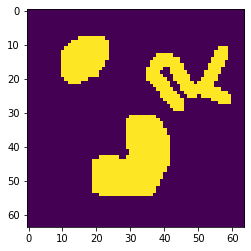

shape for label 1


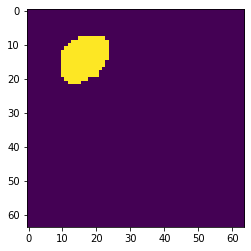

C_distance:	0.39
C_angle:	0.26
trace distance:	0.00
total complexity:	0.29
shape for label 2


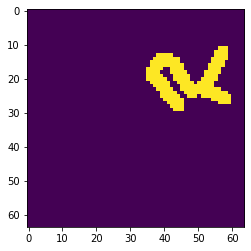

C_distance:	0.55
C_angle:	0.29
trace distance:	0.02
total complexity:	0.35
shape for label 3


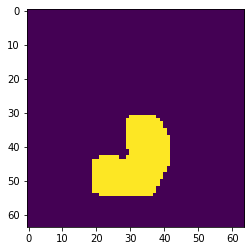

C_distance:	0.51
C_angle:	0.23
trace distance:	0.03
total complexity:	0.29


In [44]:
visualize_mask('data/test_mask.png')

full mask


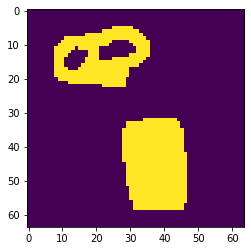

shape for label 1


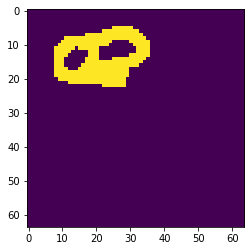

C_distance:	0.54
C_angle:	0.21
trace distance:	0.04
total complexity:	0.29
shape for label 2


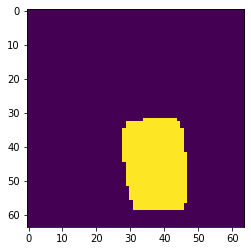

C_distance:	0.36
C_angle:	0.19
trace distance:	0.02
total complexity:	0.23


In [45]:
visualize_mask('data/test_mask2.png')

full mask


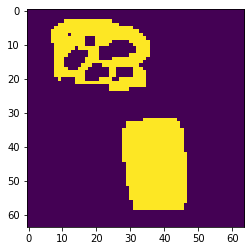

shape for label 1


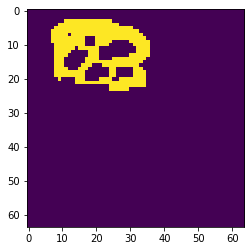

C_distance:	0.51
C_angle:	0.20
trace distance:	0.03
total complexity:	0.27
shape for label 2


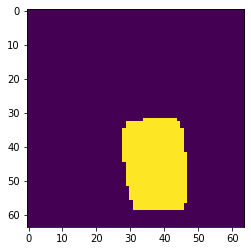

C_distance:	0.36
C_angle:	0.19
trace distance:	0.03
total complexity:	0.23


In [46]:
visualize_mask('data/test_mask3.png')